In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-27 22:48:14.955562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 22:48:15.424160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-27 22:48:16.304225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:16.325317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:16.325659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [3]:
digits.images.shape

(1797, 8, 8)

In [4]:
np.max(digits.images)

16.0

In [5]:
T=1000
beta = np.linspace(1e-4, 0.02, T)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [8,8]
tValues = np.arange(0,T)



def forwardStep(x0Image,t):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy


repeats=15
def generator():
    for imIdx in range(digits.images.shape[0]):
        image = tf.convert_to_tensor(digits.images[imIdx])
        image = (tf.cast(image, tf.float32) / 8.0) - 1
        image = tf.expand_dims(image, -1)
        x0 = image.numpy()
        tValues = np.random.choice(T,repeats, replace=False)
        for tValue in tValues:
            noise, noisy = forwardStep(x0, tValue)
            yield noisy, noise, [tValue], x0

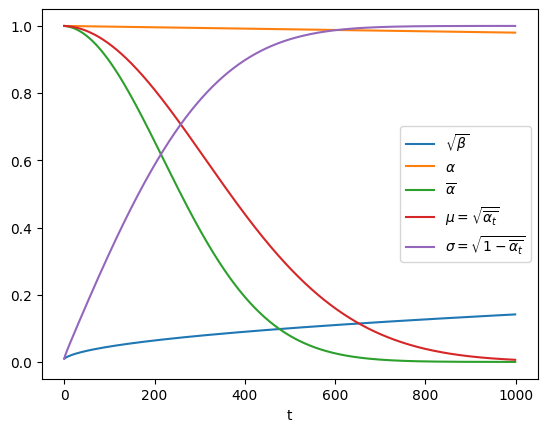

In [6]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
_ = plt.legend()
_ = plt.xlabel("t")

In [7]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [8]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[538]
(8, 8, 1)
(8, 8, 1)


2023-08-27 22:48:16.722173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:16.722564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:16.722893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:17.174575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 22:48:17.174991: I tensorflow/compile

In [9]:
test = next(g)
np.max(test[0])

2.21364610101631

Text(0.5, 1.0, 'Noise')

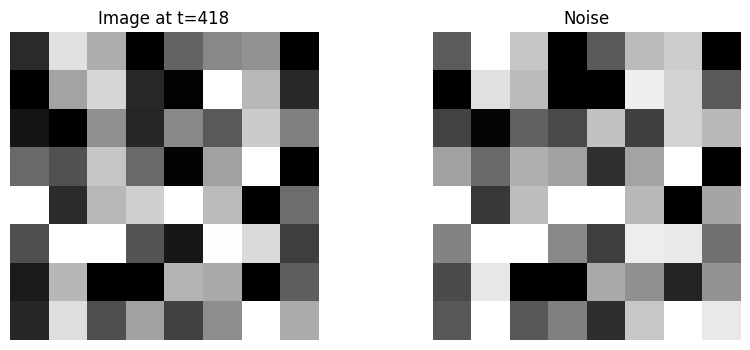

In [10]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]), cmap="gray")
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]), cmap="gray")
plt.axis('off')
plt.title("Noise")

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 7.5, 7.5, -0.5)

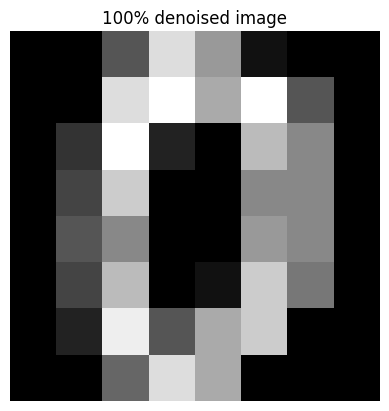

In [11]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2, cmap="gray")
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [12]:
noisyImages=[]
noises=[]
x0=digits.images[0]/8.0-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

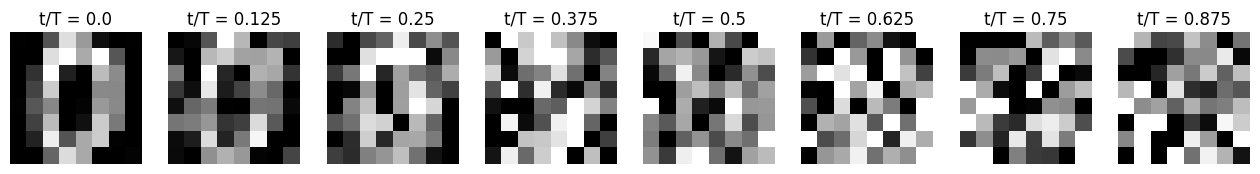

In [13]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]), cmap="gray")
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [14]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStep(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t==0:
        sample = x0Pred
        noise= np.zeros(xt.shape)
    else:
        # estimate mean
        meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))

        # compute variance
        betaPred = np.sqrt(beta[t])

        sample = meanPred + betaPred*np.random.normal(0,1,xt.shape)

        noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise

for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStep(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

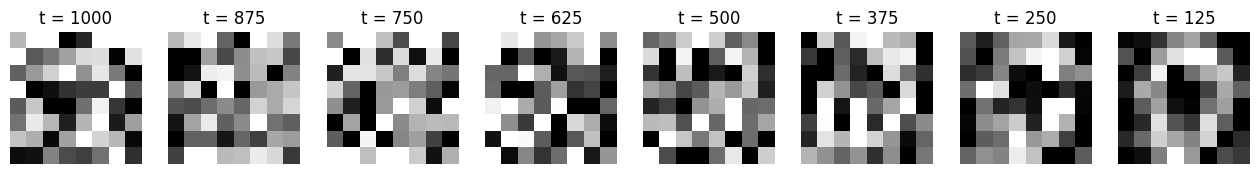

In [15]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]), cmap="gray")
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

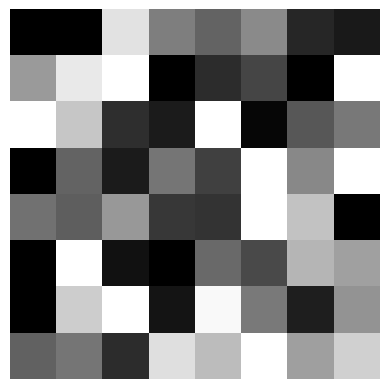

In [16]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 1), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 1), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 1), dtype=tf.float32)))
_ = plt.imshow(np.clip(list(dataset.take(20))[1][0].numpy()/2+0.5, 0,1), cmap="gray")
_ = plt.axis("off")

## Tensorflow

In [17]:
%load_ext tensorboard


Model: "SimpleUnetMNIST_K1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d_411 (Conv2D)         (None, 8, 8, 8)              80        ['input_49[0][0]']            
                                                                                                  
 conv2d_412 (Conv2D)         (None, 4, 4, 16)             1168      ['conv2d_411[0][0]']          
                                                                                                  
 conv2d_413 (Conv2D)         (None, 4, 4, 16)             2320      ['conv2d_412[0][0]']          
                                                                                 

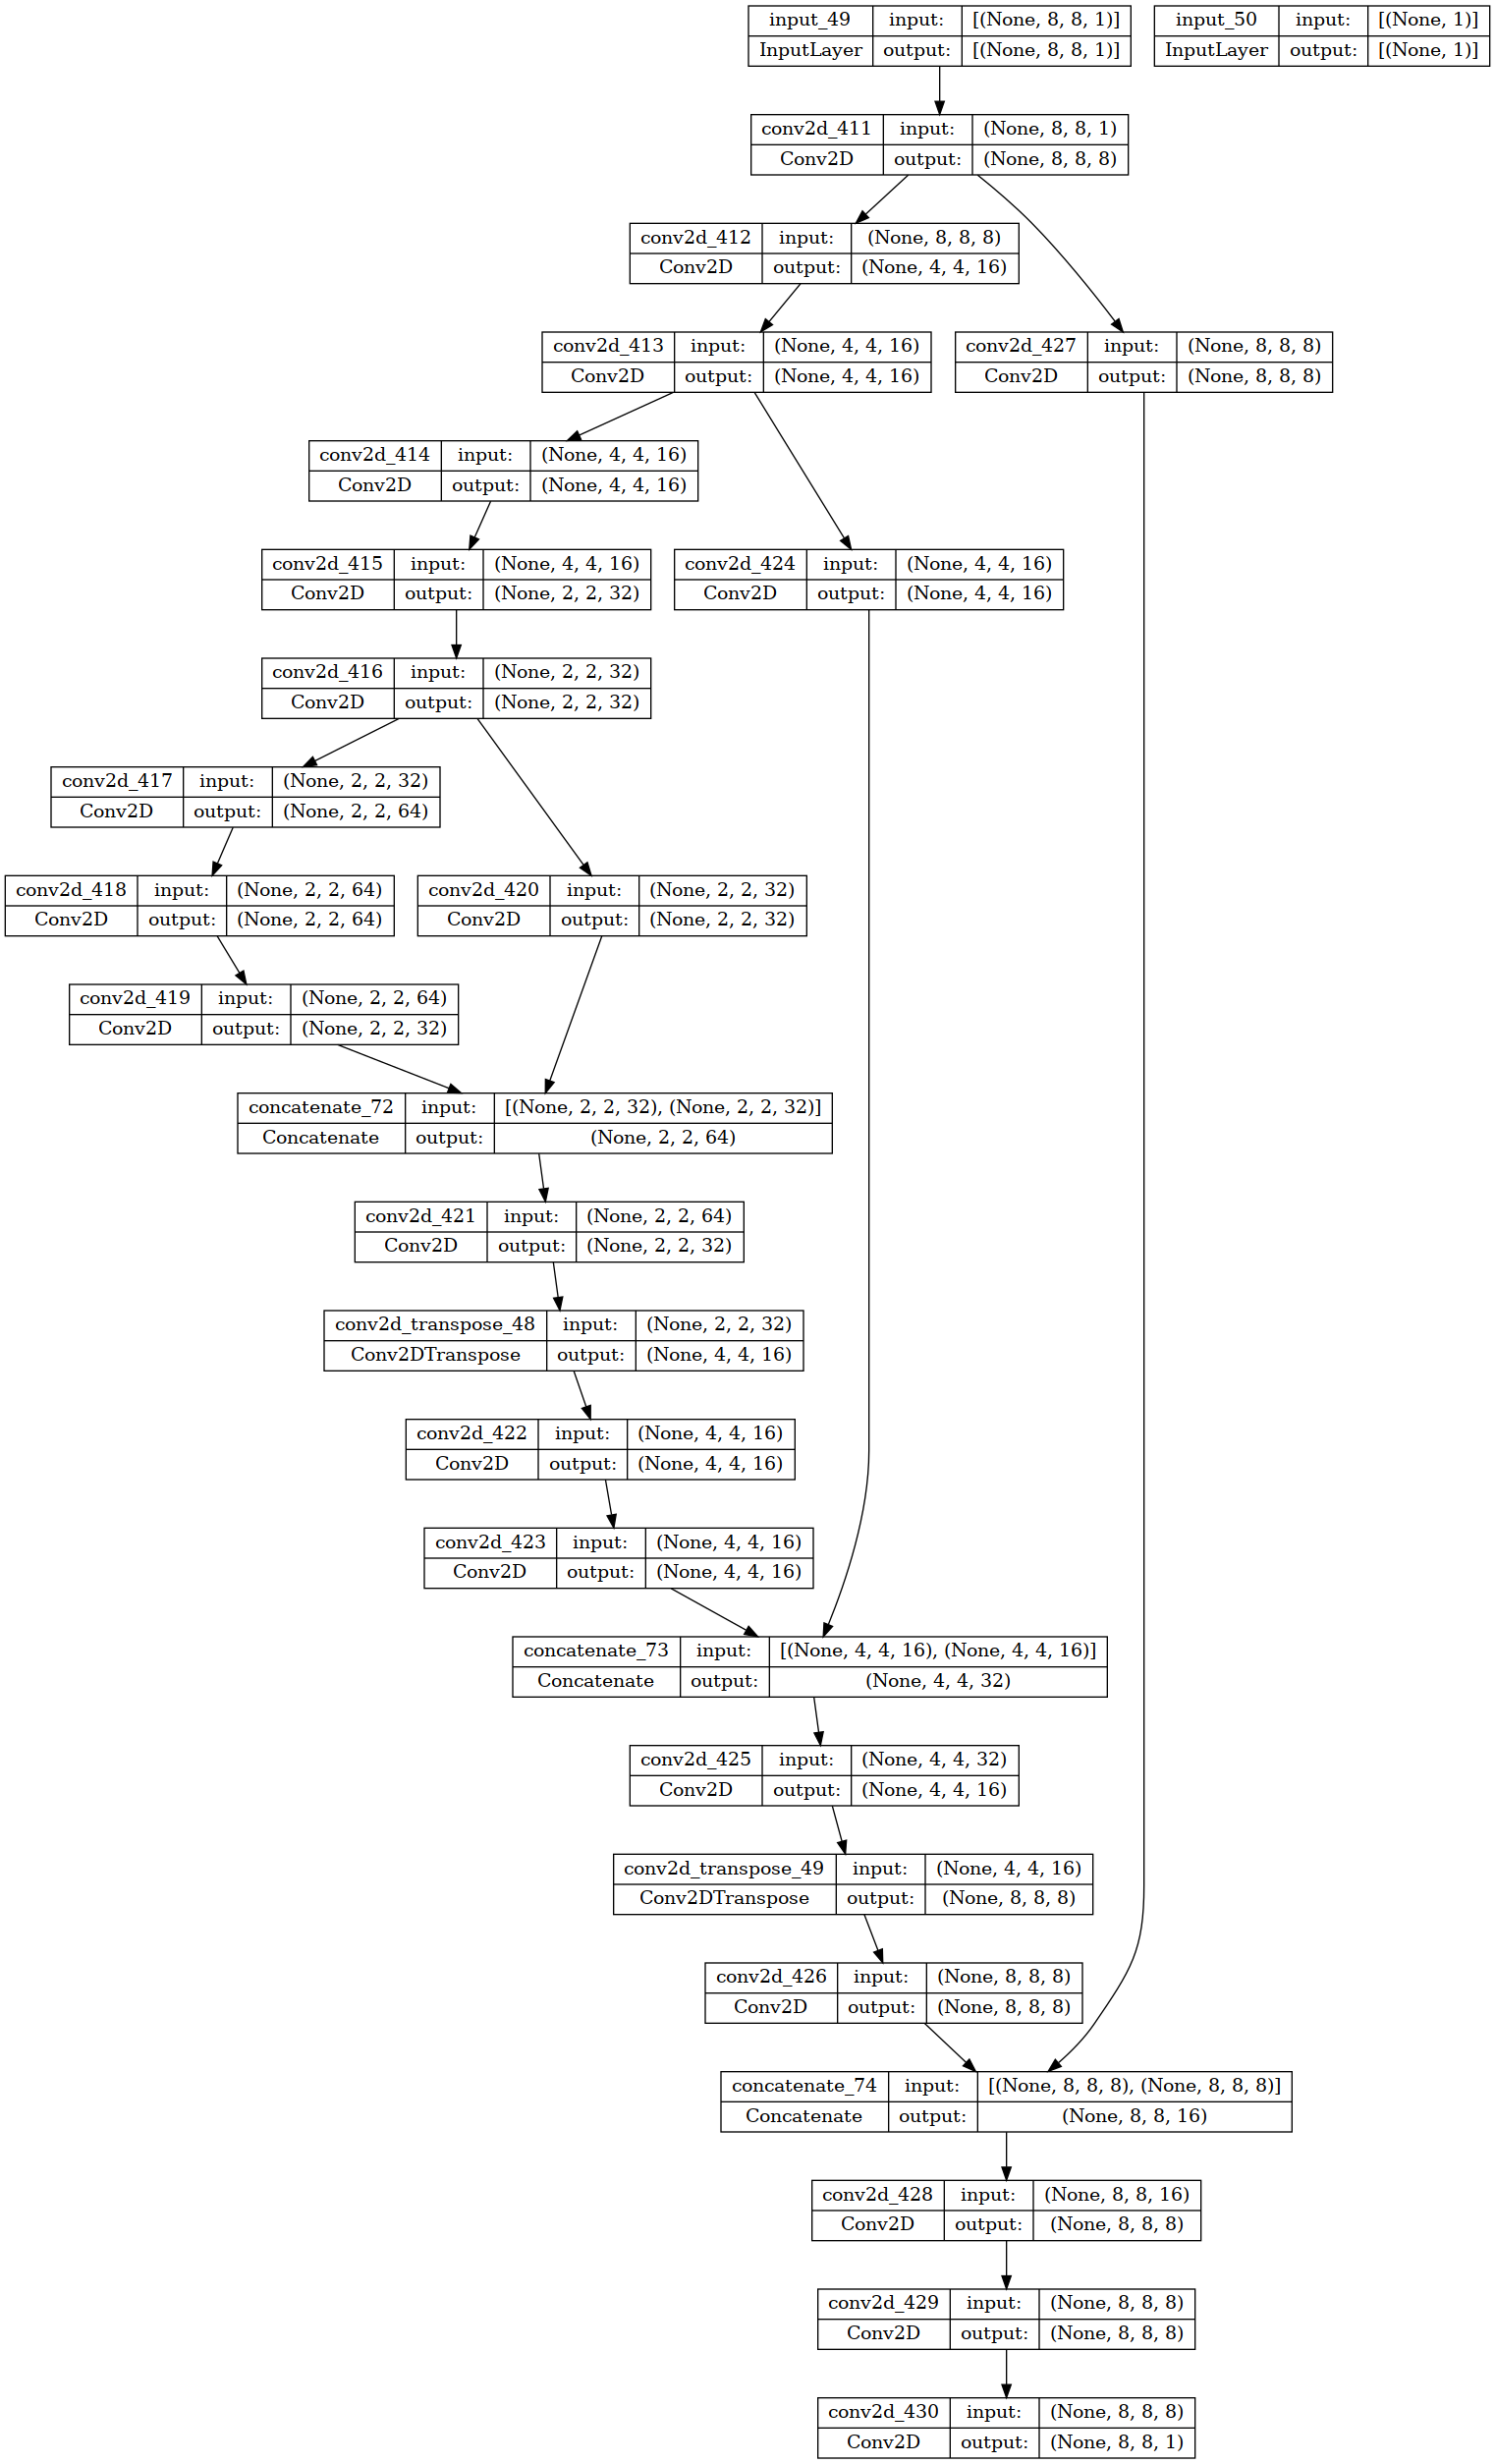

In [39]:

def createSimpleUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 1))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    # embeddedStep = tf.keras.layers.Embedding(T, 8)(stepInput)
    # stepMap = tf.repeat(embeddedStep, 8, axis=0)
    # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    # concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(inputs)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", strides=2, activation="relu")(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(xDown1)
    #4x4
    
    xDown2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xDown1)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown2)
    #2x2


    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same" )(xDown2)

    # stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=4, padding="same")(stepMap)
    # concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(K*64, 3, dilation_rate=2, padding="same", activation="relu")(xCenter)
    # 2x2



    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu")(xCenter)
    xDown2Concat = tf.keras.layers.Conv2D(K*32, 1, padding="same")(xDown2)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2Concat])
    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(K*16, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xUp2)
    #4x4

    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu")(xUp2)
    xDown1Concat = tf.keras.layers.Conv2D(K*16, 1, padding="same")(xDown1)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1Concat])
    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(K*8, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xUp1)
    #8x8

    xDown1InConcat = tf.keras.layers.Conv2D(K*8, 1, padding="same")(xDown1In)
    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1InConcat])
    x = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu")(x)

    outputs=tf.keras.layers.Conv2D(1, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnetMNIST_K{}".format(K))


model = createSimpleUnet(K=1)

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [19]:
L2=0

def downscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)
    
    return added


def upscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)

    return added


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)


def centerBlock(xIn, stepMap, ch, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    stepMap16 = tf.keras.layers.Conv2D(3, filtersize, strides=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([x, stepMap16])

    x = tf.keras.layers.BatchNormalization()(concatCenter)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = nonLocalBlock(x, ch)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    return x

def createUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 1))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 8)(stepInput)
    stepMap = tf.repeat(embeddedStep, 8, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatInput)
    
    xDown4 = downscaleBlock(xDown2, K*2, K*4, 3)
    #128

    xDown8 = downscaleBlock(xDown4, K*4, K*8, 3)
    #64


    xCenter = centerBlock(xDown8, stepMap, K*8, 3)
    #16x16


    xUp4 = upscaleBlock(xCenter, K*8, K*4, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])
    xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp2 = upscaleBlock(xUp4, K*4, K*2, 3)
    #256
    xConcat2 = tf.keras.layers.Concatenate()([xDown2, xUp2])
    
    x = tf.keras.layers.BatchNormalization()(xConcat2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs=tf.keras.layers.Conv2D(1, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_MNIST_T{}_K{}".format(T,K))


# model = createUnet(K=4)

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [20]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "diffusionModelMNIST_epoch_0"))
    startEpoch=1
else:
    startEpoch=0

In [21]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
  initInput = tf.random.normal((3, *IMAGE_SIZE, 1), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(0,T)[::-1]:
      pred = model((samples[-1], tf.constant([t, t, t])), training=False)
      xt = samples[-1]
      
      # sample, noise = backwardStep(xt, t, x0Pred=predX0)
      sample, noise = backwardStep(xt, t, predNoise=pred)

      samples.append(sample)

  _ = plt.figure(figsize=(12,8))

  sampleIdx = np.linspace(0, T, 5)

  for j in range(3):
    for i in range(5):
        _ = plt.subplot(3, 5, j*5+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:],cmap='gray')
        if summary_writer is not None:
           with summary_writer.as_default():
              tf.summary.image("Training data", postprocessImage(samples[int(sampleIdx[-1])]), step=maxStep*epoch+step)
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusionMNIST", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [22]:
class MSESSIMLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super().__init__(name="MSE_SSIM_Loss")
        assert(alpha<1.0)
        self.alpha = tf.constant(alpha)
        
    def call(self, yTrue, yPred):
        mse =  tf.math.reduce_mean(tf.math.square(yPred - yTrue))
        ssim = tf.image.ssim(tf.clip_by_value(yPred,-1,1)/2+0.5, tf.clip_by_value(yTrue,-1,1)/2+0.5, max_val=1.0)
        ssimLoss =  1-tf.math.reduce_mean(ssim, axis=-1)
        return (1-self.alpha)*mse + self.alpha*ssimLoss

testLoss = MSESSIMLoss(0.2)
testLoss(tf.ones([1,20,20,3]), tf.ones([1,20,20,3])*0.9)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0084743025>

In [23]:

BATCH_SIZE=64
LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=10
epochs = 201
saveModel=False



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=8e-5)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = MSESSIMLoss(0.1)

mseMetric = tf.keras.metrics.MeanSquaredError()


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
datasetShuffled = dataset.shuffle(1000)
batchedDataset = datasetShuffled.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(noisyImage, noise, t):
    with tf.GradientTape() as tape:
        predicted = model((noisyImage, t), training=True) 

        loss = lossFn(predicted, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    mseMetric.update_state(predicted,noise)

    return loss, predicted



maxStep=digits.images.shape[0]*repeats//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, mseMetric.result().numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', mseMetric.result().numpy(), step=maxStep*epoch+step)
                summary_writer.flush()
        
    if epoch % SAVE_IMAGE_INTERVAL==0:
        saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    mseMetric.reset_state()

    if saveModel:
      model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0


2023-08-27 22:48:20.718797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-27 22:48:21.384972: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7b392aa570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-27 22:48:21.385015: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-27 22:48:21.388478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-27 22:48:21.467891: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0/Step 0, Loss: 1.0041
Epoch 0/Step 5, Loss: 0.9973
Epoch 0/Step 10, Loss: 0.9885
Epoch 0/Step 15, Loss: 0.9916
Epoch 0/Step 20, Loss: 0.9949
Epoch 0/Step 25, Loss: 0.9933
Epoch 0/Step 30, Loss: 0.9940
Epoch 0/Step 35, Loss: 0.9967
Epoch 0/Step 40, Loss: 0.9978
Epoch 0/Step 45, Loss: 0.9973
Epoch 0/Step 50, Loss: 0.9969
Epoch 0/Step 55, Loss: 0.9968
Epoch 0/Step 60, Loss: 0.9968
Epoch 0/Step 65, Loss: 0.9973
Epoch 0/Step 70, Loss: 0.9982
Epoch 0/Step 75, Loss: 0.9982
Epoch 0/Step 80, Loss: 0.9977
Epoch 0/Step 85, Loss: 0.9975
Epoch 0/Step 90, Loss: 0.9978
Epoch 0/Step 95, Loss: 0.9977
Epoch 0/Step 100, Loss: 0.9973
Epoch 0/Step 105, Loss: 0.9976
Epoch 0/Step 110, Loss: 0.9973
Epoch 0/Step 115, Loss: 0.9967
Epoch 0/Step 120, Loss: 0.9963
Epoch 0/Step 125, Loss: 0.9964
Epoch 0/Step 130, Loss: 0.9962
Epoch 0/Step 135, Loss: 0.9962
Epoch 0/Step 140, Loss: 0.9958
Epoch 0/Step 145, Loss: 0.9951
Epoch 0/Step 150, Loss: 0.9944
Epoch 0/Step 155, Loss: 0.9943
Epoch 0/Step 160, Loss: 0.9936

In [ ]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]

for t in np.arange(0,T)[::-1]:
    predNoise = model((samples[-1], tf.constant([t,t])))
    xt = samples[-1]
    
    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, T, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

In [ ]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)
plt.title("Predicted Noise")
plt.subplot(1,2,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+1)/2)

In [ ]:
testTNum = testT.numpy()[0][0]

In [ ]:
denoised = (testImage - (1-alpha[testTNum])/np.sqrt(1-alphaBar[testTNum])*predNoise)/np.sqrt(alpha[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised Image by 1 step")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)

## Hparam optimizer

In [36]:
from tensorboard.plugins.hparams import api as hp

HP_K = hp.HParam('K', hp.Discrete([4,8,16]))
HP_LR = hp.HParam('lr', hp.Discrete([1e-4, 5e-4, 1e-3, 5e-3] ))

METRIC_HP = 'loss'

with tf.summary.create_file_writer(os.path.join(DATA_PATH,'logs/hparam_tuning')).as_default():
  hp.hparams_config(
    hparams=[HP_K, HP_LR],
    metrics=[hp.Metric(METRIC_HP, display_name='MSE')],
  )

def trainTestModel(hparams):
  model = createSimpleUnet(K=hparams[HP_K])

    
  BATCH_SIZE=64
  epochs = 10


  optimizer = tf.keras.optimizers.AdamW(learning_rate=hparams[HP_LR])
  lossFn = tf.keras.losses.MeanSquaredError()
  mseMetric = tf.keras.metrics.MeanSquaredError()

  # batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
  datasetShuffled = dataset.shuffle(1000)
  batchedDataset = datasetShuffled.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)


  @tf.function()
  def trainStep(noisyImage, noise, t):
      with tf.GradientTape() as tape:
          predicted = model((noisyImage, t), training=True) 

          loss = lossFn(predicted, noise)


      grads = tape.gradient(loss, model.trainable_weights)

      optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

      mseMetric.update_state(predicted,noise)

      return loss, predicted



  maxStep=digits.images.shape[0]*repeats//BATCH_SIZE


  for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
      print("start epoch ", epoch)

      # Iterate over the batches of the dataset.
      for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
          loss, predictedImage = trainStep(noisyImage, noise, t)

      maxStep=step

      if not epoch == epochs-1:
        mseMetric.reset_state()

  return mseMetric.result().numpy()

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    loss = trainTestModel(hparams)
    tf.summary.scalar(METRIC_HP, loss, step=1)

In [37]:
session_num = 0

for K in HP_K.domain.values:
  for lr in HP_LR.domain.values:
    hparams = {
        HP_K: K,
        HP_LR: lr,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'K': 2, 'lr': 1e-05}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-1
{'K': 2, 'lr': 5e-05}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-2
{'K': 2, 'lr': 0.0001}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-3
{'K': 2, 'lr': 0.0005}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-4
{'K': 4, 'lr': 1e-05}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Star

2023-08-28 00:13:29.096642: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-13
{'K': 16, 'lr': 5e-05}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-14
{'K': 16, 'lr': 0.0001}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4
start epoch  5
start epoch  6
start epoch  7
start epoch  8
start epoch  9
--- Starting trial: run-15
{'K': 16, 'lr': 0.0005}
start epoch  0
start epoch  1
start epoch  2
start epoch  3
start epoch  4


KeyboardInterrupt: 